### importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import pickle

## Loading the data

data source: https://www.kaggle.com/datasets/alextrinity/sqlinjectionextend

In [3]:
data=pd.read_csv('sqli-extended.csv')

### How data looks like

In [4]:
data.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1


### How big is data

In [5]:
data.shape

(109518, 2)

## EDA

### Class distribution of data

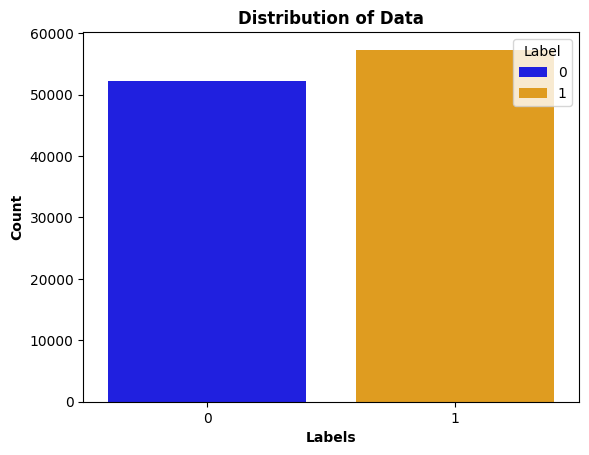

In [6]:
sns.countplot(x='Label',data=data,palette=['blue','orange'],hue="Label")
plt.xlabel("Labels",weight='bold')
plt.ylabel("Count",weight='bold')
plt.title("Distribution of Data",weight='bold')
plt.show()

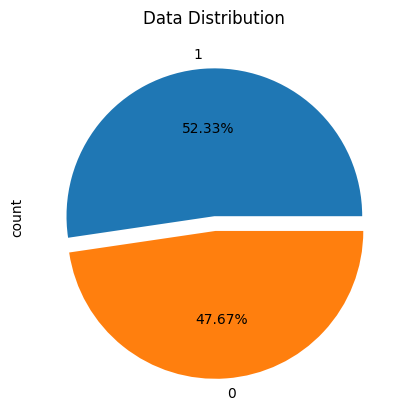

In [7]:
data['Label'].value_counts().plot(kind='pie',autopct="%.2f%%",explode=[0,0.1])
plt.title("Data Distribution")
plt.show()

### Calculating the frequency of words in Sentences

In [8]:
def freq_word(text):
  word_count=[]
  for word in text.split():
    word_count.extend(word)
  #Generating word frequences using value_counts in word-list
  word_frequency=pd.Series(word_count).value_counts()
  word_frequency[:100]
  return word_frequency

In [9]:
frequency=freq_word(data.Sentence.str)

In [10]:
frequency

the                                                                                                                  235021
)                                                                                                                    226732
(                                                                                                                    201043
and                                                                                                                  156567
a                                                                                                                    139755
                                                                                                                      ...  
htxi13795amje37pqpk5msc0kdog2vyztl1aw                                                                                     1
ponytcto                                                                                                                  1
03l66loh

### Generating word-clouds

In [12]:
from wordcloud import WordCloud

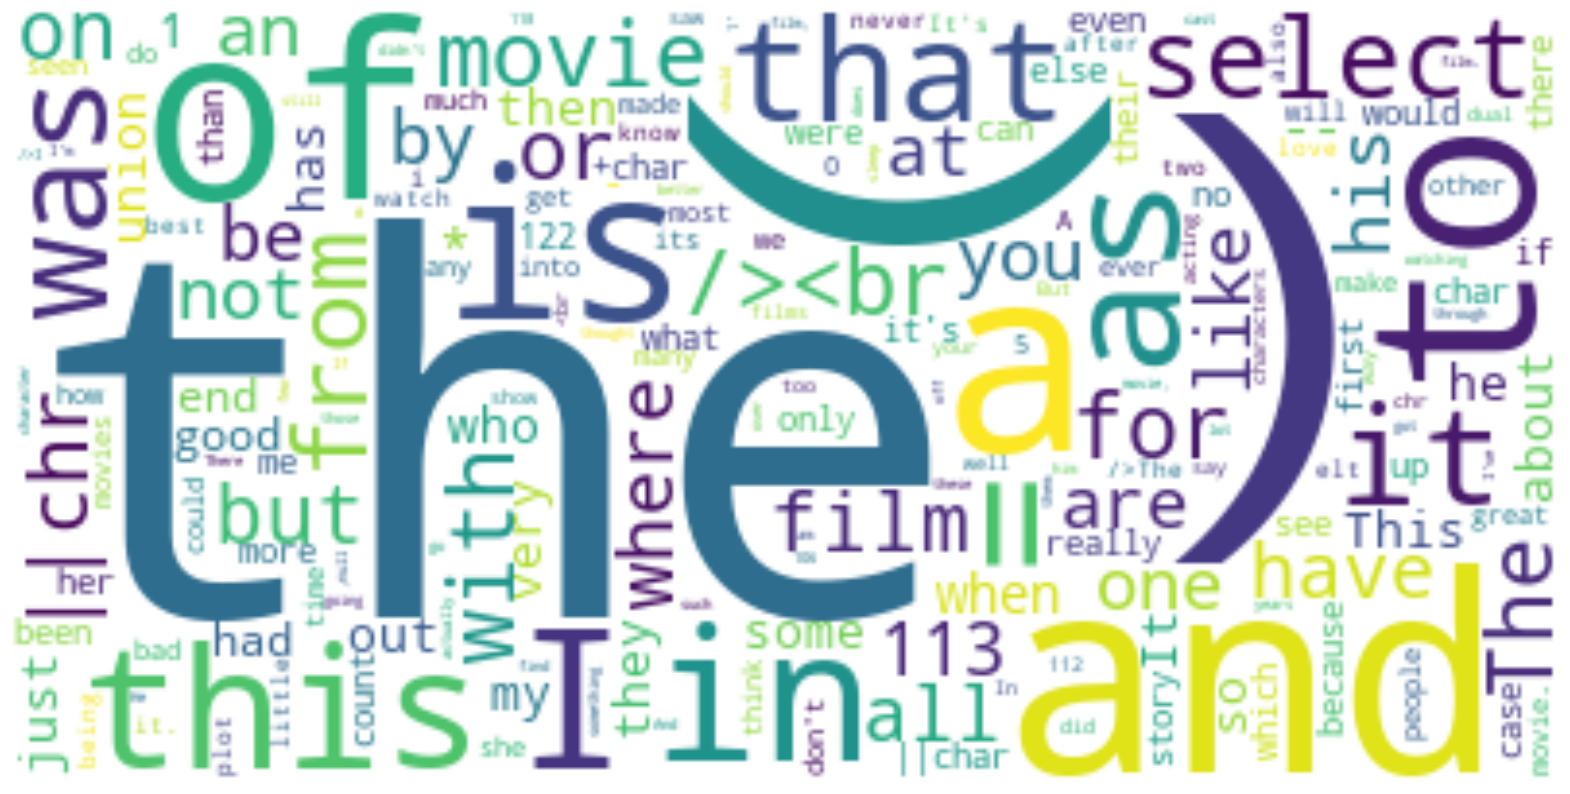

In [13]:
plt.figure(figsize=(20,20))
wordcl=WordCloud(max_words=200,width=400,height=200,background_color='white').generate_from_frequencies(frequency)
plt.axis('off')
plt.imshow(wordcl,interpolation='bilinear')
plt.show()

### Word cloud for Sentences which where we are under sql attack

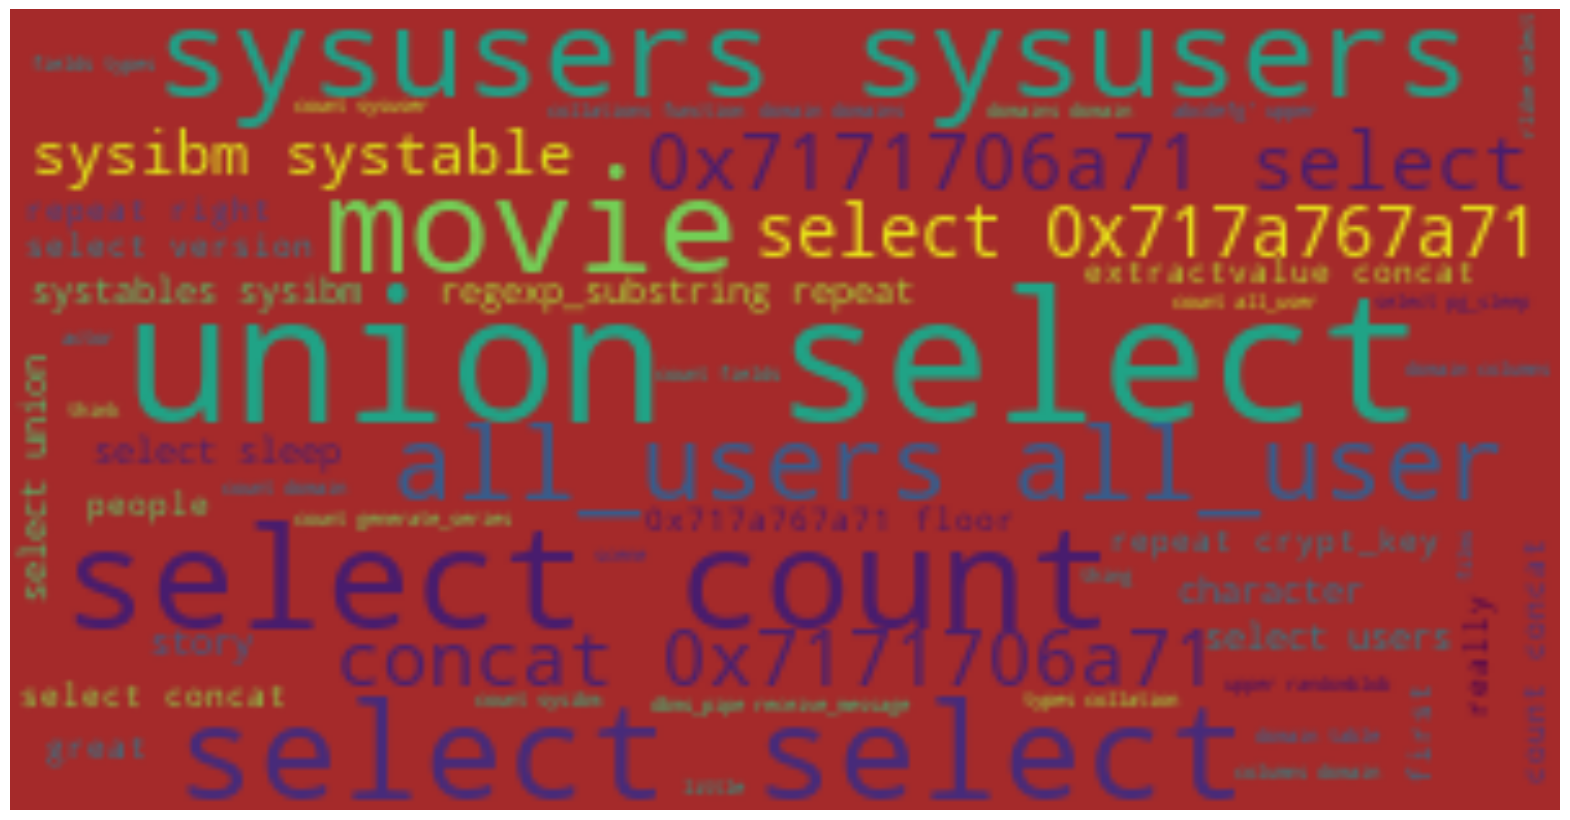

In [14]:
plt.figure(figsize=(20,20))
WrdCld=WordCloud(max_words=400,width=300,height=155,min_word_length=5,background_color='brown').generate(" ".join(data[data.Label==1].Sentence))
plt.axis('off')
plt.imshow(WrdCld,interpolation='bilinear')
plt.show()

### Word cloud for Sentences which where we are not under sql attack

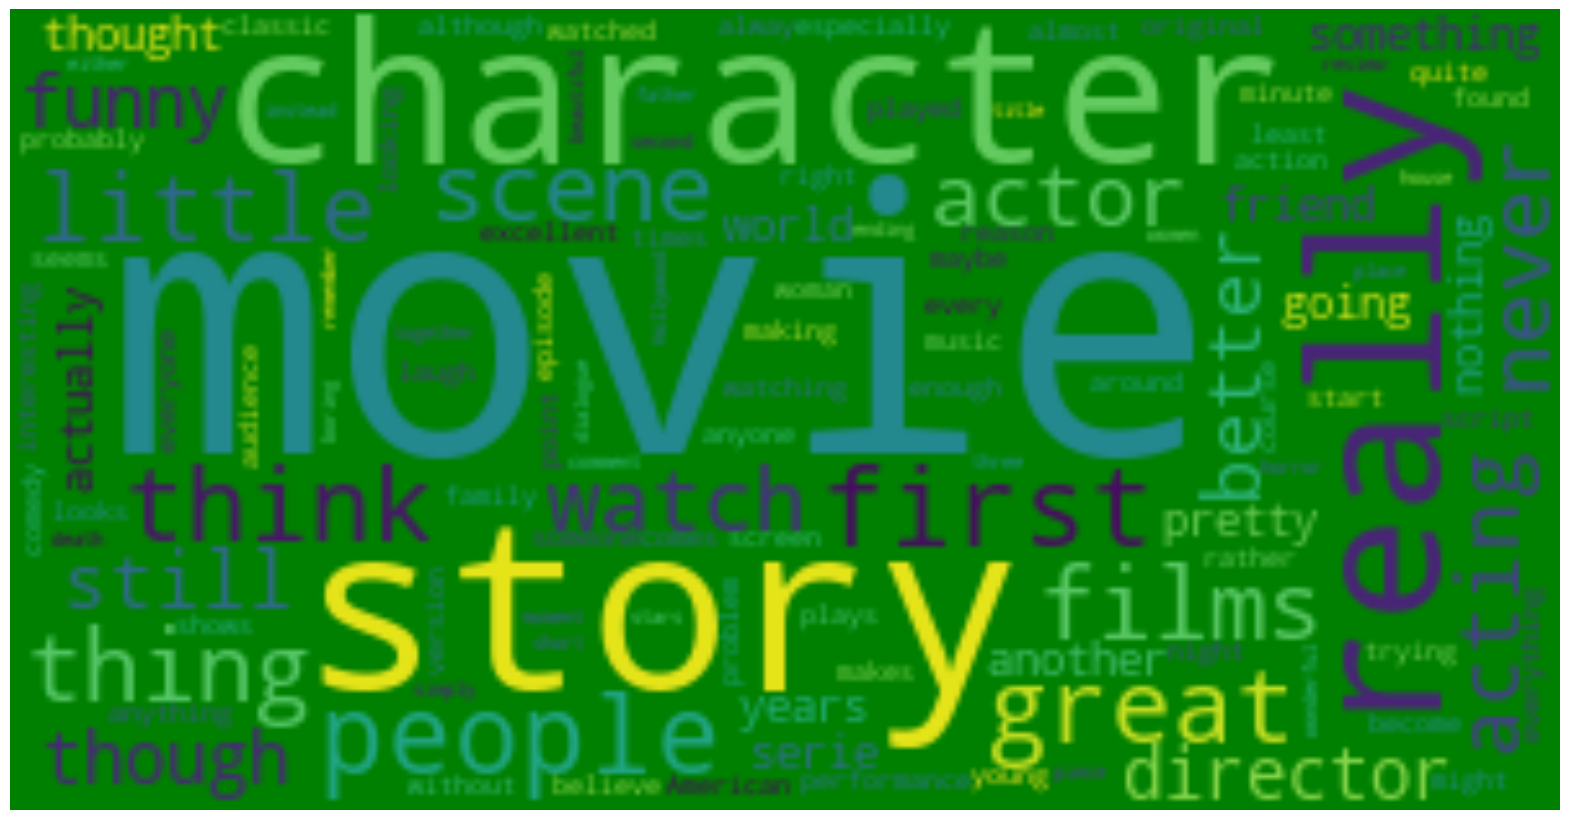

In [15]:
plt.figure(figsize=(20,20))
WrdCld2=WordCloud(max_words=400,width=300,height=155,min_word_length=5,background_color='green').generate(" ".join(data[data.Label==0].Sentence))
plt.axis('off')
plt.imshow(WrdCld2,interpolation='bilinear')
plt.show()

## Data preprocessing

## 

### Checking missing values in the dataset

In [16]:
data.isna().sum()

Sentence    0
Label       0
dtype: int64

### Checking the duplicate rows in the dataset

In [17]:
data.duplicated().sum()

2077

### Removing the duplicate values from the dataset

In [18]:
data.drop_duplicates(keep=False,inplace=True)

### Rechecking the duplicate values

In [19]:
data.duplicated().sum()

0

### Checking the dtype of the columns

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106967 entries, 1 to 109517
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  106967 non-null  object
 1   Label     106967 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Removing some of the punctutations

In [21]:
def remove_punctuation(text):
    text=re.sub(r"[\"#$'.,@]+"," ",text)
    return text

### Applying remove punctutaion on all sentences

In [22]:
data['Sentence']=data['Sentence'].apply(remove_punctuation)

In [23]:
stops=frequency[:100]
stops.pop("(")
stops.pop(")")
stops.pop("=")

68577

### Removing stopwords from the Sentences

In [24]:
def remove_stope(text):
    new_text=[]
    tokens=text.split()
    for word in tokens:
        if not word in stops:
            new_text.append(word)     
    return " ".join(new_text)

### Removing the stopwords

In [25]:
data['Sentence']=data['Sentence'].apply(remove_punctuation)

### 

### Converting text to numeric using tfidf

In [26]:
x=data['Sentence']
y=data['Label']

## Splitting the data into the train and test

In [27]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(85573,)
(21394,)
(85573,)
(21394,)


## Creating the pipeline for training and evaluating, Machine Learning Model

In [29]:
pipeline1=Pipeline([
    ('tf_idf',TfidfVectorizer(max_features=1000)),
    ('rf',RandomForestClassifier(n_estimators=10,max_features=0.75,random_state=42))
])

In [30]:
pipeline1

Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=1000)),
                ('rf',
                 RandomForestClassifier(max_features=0.75, n_estimators=10,
                                        random_state=42))])

### Training Random Forest model

In [31]:
pipeline1.fit(x_train,y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=1000)),
                ('rf',
                 RandomForestClassifier(max_features=0.75, n_estimators=10,
                                        random_state=42))])

### deriving predictions

In [32]:
yp=pipeline1.predict(x_test)

### Evaluating our random Forest model

In [33]:
acc=accuracy_score(y_test,yp)
print(f"Testing-Accuracy:",acc)

## predictions on training data
yp_train=pipeline1.predict(x_train)
## training accuracy 
acct=accuracy_score(y_train,yp_train)
print(f"Training-Accuracy:",acct)


Testing-Accuracy: 0.9716275591287277
Training-Accuracy: 0.9939116310051067


### Confusion Matrix

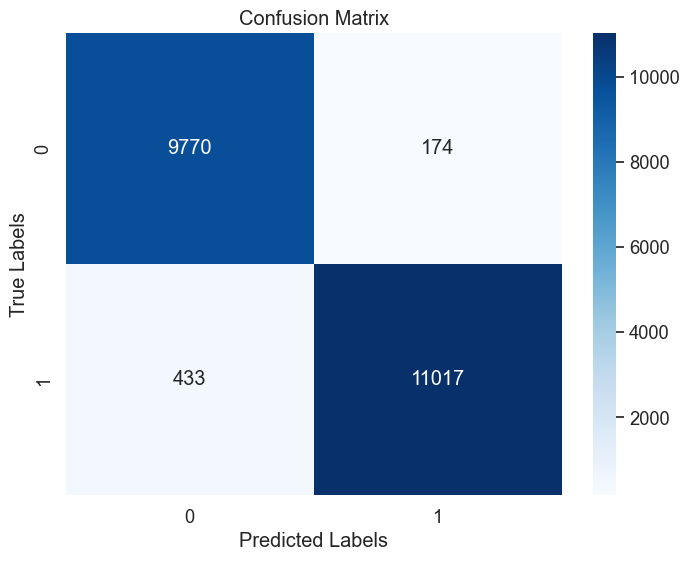

In [34]:
cm1=confusion_matrix(y_test,yp)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Classification report

In [35]:
cr1=classification_report(y_test,yp)
print(cr1)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9944
           1       0.98      0.96      0.97     11450

    accuracy                           0.97     21394
   macro avg       0.97      0.97      0.97     21394
weighted avg       0.97      0.97      0.97     21394



### Saving pkl file

In [66]:
# save the model to disk
filename = 'randomforest.pkl'
pickle.dump(pipeline1, open(filename, 'wb'))

## Training Gradient Boosting Classifier model

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline2=Pipeline([
    ('tf_idf',TfidfVectorizer(max_features=1000)),
    ('rf',GradientBoostingClassifier(n_estimators=300,random_state=42))
])

In [37]:
pipeline2

Pipeline(steps=[('tf_idf', TfidfVectorizer(max_features=1000)),
                ('rf',
                 GradientBoostingClassifier(n_estimators=300,
                                            random_state=42))])

### Training and prediction of Gradient boosting model


In [38]:
## training
pipeline2.fit(x_train,y_train)
## prediction
pipeline2.predict(x_test)

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

### Evaluating Gradient boosting Model

In [58]:
acc2=accuracy_score(y_test,yp)
print(f"Testing-Accuracy:",acc2)

## predictions on training data
yp_train2=pipeline2.predict(x_train)
## training accuracy 
acct2=accuracy_score(y_train,yp_train2)
print(f"Training-Accuracy:",acct2)

Testing-Accuracy: 0.9716275591287277
Training-Accuracy: 0.972432893552873


### Confusion Matrix

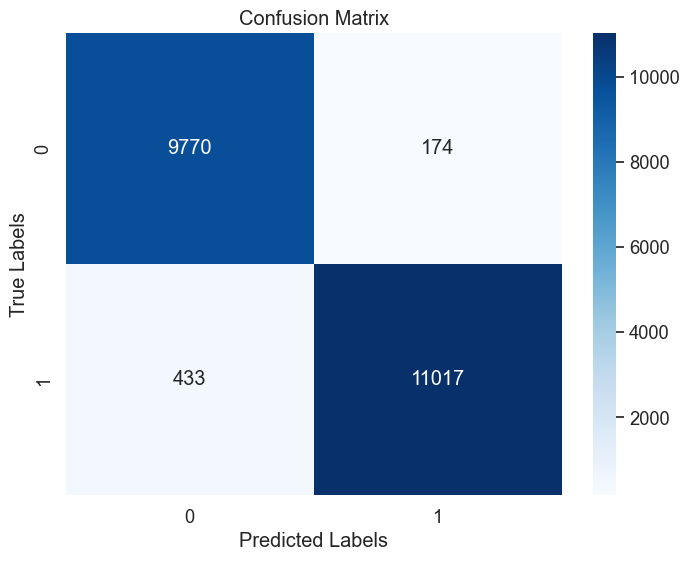

In [59]:
cm2=confusion_matrix(y_test,yp)
# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Classification report

In [60]:
cr2=classification_report(y_test,yp)
print(cr2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9944
           1       0.98      0.96      0.97     11450

    accuracy                           0.97     21394
   macro avg       0.97      0.97      0.97     21394
weighted avg       0.97      0.97      0.97     21394



In [65]:
# save the model to disk
filename = 'gradientboost.pkl'
pickle.dump(pipeline2, open(filename, 'wb'))

## Applying neural network 

### Converting the text to numeric features using tfidf

In [72]:
X = data['Sentence']
vectorizer=TfidfVectorizer(max_features=1000)
tfidf_X=vectorizer.fit_transform(X)
y = data.Label

### Splitting the data into train and test

In [73]:
x_trainn, x_testt, y_trainn, y_testt = train_test_split(
    tfidf_X, y, test_size=0.2,stratify=y, random_state=42
)

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization

In [85]:
model=Sequential()
model.add(Dense(100,activation='relu',kernel_initializer='uniform',input_dim=x_trainn.shape[1]))
model.add(BatchNormalization())
model.add(Dense(56,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 56)             │         5,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,013 (421.93 KB)

 Trainable params: 107,813 (421.14 KB)

 Non-trainable params: 200 (800.00 B)

### Training our Neural network

In [86]:
history=model.fit(x_trainn,y_trainn,epochs=10,validation_data=(x_testt,y_testt),batch_size=64,verbose=1)

Epoch 1/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9209 - loss: 0.2132 - val_accuracy: 0.9629 - val_loss: 0.1135
Epoch 2/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9709 - loss: 0.0971 - val_accuracy: 0.9737 - val_loss: 0.0899
Epoch 3/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9756 - loss: 0.0799 - val_accuracy: 0.9745 - val_loss: 0.0894
Epoch 4/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9781 - loss: 0.0675 - val_accuracy: 0.9747 - val_loss: 0.0959
Epoch 5/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9785 - loss: 0.0620 - val_accuracy: 0.9725 - val_loss: 0.1090
Epoch 6/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9828 - loss: 0.0465 - val_accuracy: 0.9716 - val_loss: 0.1282
Epoch 7/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9865 - loss: 0.0396 - val_accuracy: 0.9706 - val_loss: 0.1562
Epoch 8/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9884 - loss: 0.0334 - 

### Saving our neural network

In [87]:
## Saving the model
model.save("SQl_injection_detection.h5")

### Evaluating our neural network model

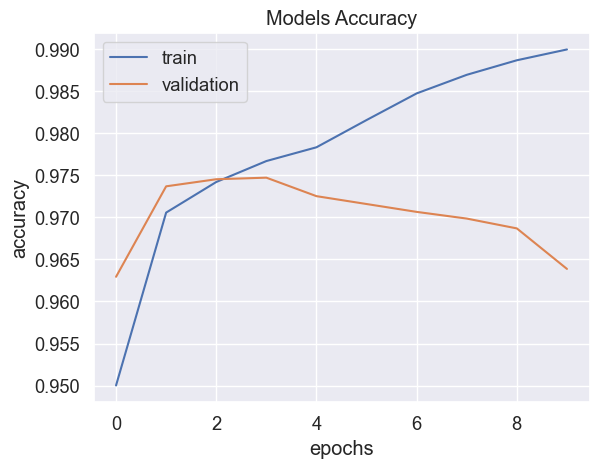

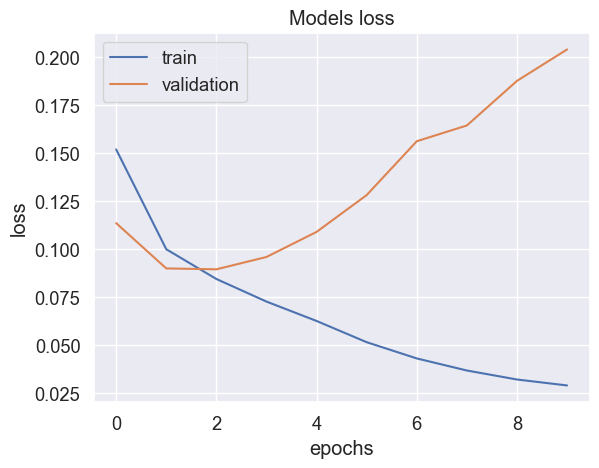

In [88]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Models loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Accuracy and losss

In [91]:
loss,accuracy=model.evaluate(x_testt,y_testt)
print("Testing Accuracy of ANN:",accuracy)
print("Loss of ANN",loss)

669/669 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9653 - loss: 0.1910
Testing Accuracy of ANN: 0.9638683795928955
Loss of ANN 0.20410040020942688


### Making prediction

In [92]:
y_pred=model.predict(x_testt)

669/669 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [93]:
y_pred=np.where(y_pred>0.5,1,0)

### Accuracy Score

In [94]:
accuracy_score(y_testt,y_pred)

0.9638683743105544

### Confusion Matrix

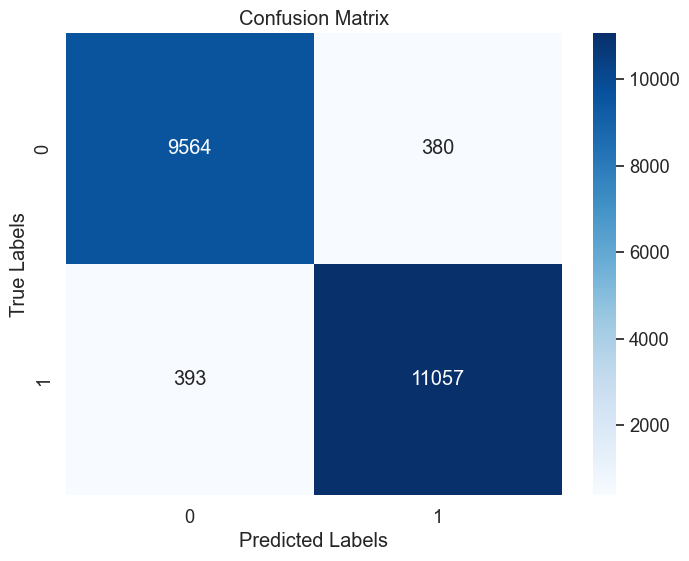

In [95]:
cm=confusion_matrix(y_test,y_pred)
# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [96]:
cr=classification_report(y_testt,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9944
           1       0.97      0.97      0.97     11450

    accuracy                           0.96     21394
   macro avg       0.96      0.96      0.96     21394
weighted avg       0.96      0.96      0.96     21394

